<a href="https://colab.research.google.com/github/NairaMo/Graduation/blob/main/trialhuggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

# 1. إعداد التحويلات للصور
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. تحميل البيانات
train_dir = '/content/drive/MyDrive/dogs&cats/training_set/training_set'
test_dir = '/content/drive/MyDrive/dogs&cats/test_set/test_set'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# 3. تحميل الموديل
model_name = "tangocrazyguy/resnet-50-finetuned-cats_vs_dogs"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=3,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. إعداد Optimizer و Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# 5. Loop للتدريب
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# 6. التقييم على Testing Data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=images).logits
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at tangocrazyguy/resnet-50-finetuned-cats_vs_dogs and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([2, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.6209, Accuracy: 86.49%
Epoch 2/2, Loss: 0.1682, Accuracy: 98.15%
Test Accuracy: 99.04%


Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1011
        dogs       0.99      0.98      0.99      1012
       other       0.99      1.00      0.99      1403

    accuracy                           0.99      3426
   macro avg       0.99      0.99      0.99      3426
weighted avg       0.99      0.99      0.99      3426



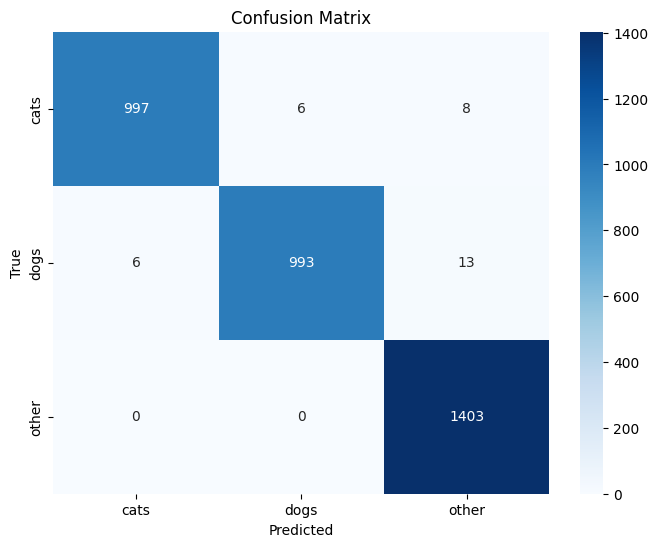

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# نجهز الموديل للتقييم
model.eval()

# نجهز أماكن تخزين النتائج
all_preds = []
all_labels = []

# بدون حساب Gradient (للتسريع)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=images).logits
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# نطبع Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# نرسم Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# احفظ الموديل
model.save_pretrained("/content/drive/MyDrive/my_finetuned_model")

# احفظ ال feature extractor (مهم لو بتستعمليه)
# Load the feature extractor
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

feature_extractor.save_pretrained("/content/drive/MyDrive/my_finetuned_model")


preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


['/content/drive/MyDrive/my_finetuned_model/preprocessor_config.json']

In [ ]:
save_path = "/content/drive/MyDrive/final_cat_dog_other_model.pth"
torch.save(model.state_dict(), save_path)

print("Model saved successfully as .pth!")


Model saved successfully as .pth!
